# Data preparation 2

### Removing labels with low occurence (below ~200)
removing labels with low occurrence in the dataset can be beneficial for various reasons. The main reason is that low occurrence labels can introduce bias in the model during training. Bias occurs when the model becomes too specialized on a particular label, and its generalization ability suffers, leading to poor performance on unseen data. This is especially true for CNNs since they tend to overfit on rare labels due to their large number of parameters.

It can also improve the efficiency of the training process. When the number of labels is reduced, the model needs to learn fewer classes, which can reduce the time and computational resources required for training. Additionally, removing low occurrence labels can lead to a more balanced dataset, where each label has a similar number of samples. A balanced dataset can lead to a better training experience and can help prevent overfitting.

### Have a balanced amount of data for each labels 
it's essential to have a balanced dataset. By doing so, we ensure that our model is exposed to enough data for each category and can learn to distinguish between them accurately.
By doing so we can reduce the bias and improve the overall performance of our CNN model.
To maintain the integrity of our *juicy* dataset, we have opted not to remove thousands of samples. Instead, we have introduced label weighting to adjust their significance during model training, allowing us to appropriately account for the prevalence of certain labels.. 

### MAYBE increase sample rate of MEL-spectrogramms
By increasing the sample rate, the MEL-spectrogram can capture more details about the temporal variations in the audio signal. This can be particularly important for tasks such as speech recognition, where the timing of phonemes and words can be critical for accurate recognition.

Also since the audio files used for this task are around 2 seconds or shorter, increasing the sample rate can help capture more information about the audio signal during that short duration.

However, it is important to note that increasing the sample rate of MEL-spectrograms also increases the computational requirements of the CNN, as well as the memory requirements for storing the input data.

### MAYBE create a dictionnary 
by creating a dictionnary {"Emotion": emotion,
                            "Path": file_path
                             }
we might make our life easier to then get back the data we want and create our dataframe.

### MAYBE
Using a smaller portion of our dataset might be useful to do more computations. We have thousands of audio files and every comoputations makes it very long to try/retry stuff.
but we have to make it randomly to avoid bias, so first we put everything in a dictionnary, and then we pick randomly some of them, like 100 of each labels ?

In [1]:
import matplotlib.pyplot as plt  #MAKE SURE TO IMPORT MATPLOTLIB BEFORE LIBROSA, otherwise matplolib will return errors somehow..
import os
import librosa
import librosa.display
import re
from sklearn.preprocessing import OneHotEncoder
import numpy as np

label_dir = "../labels/"
audio_dir = "../audio/"

all_labels_version1 = []

all_chunks = []

all_audios = []  #only here for stats
dico_emotion_url ={}

# iterate over the files in the directory, grouped by three
for i in range(0, len(os.listdir(label_dir)), 3):
    if os.listdir(label_dir)[i].endswith('.txt'):
        tmp_emotion1 =[]

        tmp_wav_file = []
        # read the content of each file
        with open(os.path.join(label_dir, os.listdir(label_dir)[i])) as f1:
            for line in f1:
                tmp_emotion1.append(re.search(r':(\w+)', line)[1])
                tmp_wav_file.append(re.search(r'(\w+)',line)[1])
                
            #exemple tmp_wav_file[i] -> Ses01F_impro02_F005 :Sadness; ()
            #example2                -> Ses01F_script01_1_F000 :Fear; ()
            for i in range(len(tmp_wav_file)):
                first_matching_file = None
                reg_session = re.search(r'Ses(\d+)', tmp_wav_file[i])[1]
                reg_impro = re.search(r'\d{2}([A-Za-z].*?_[A-Za-z].*?)_[A-Z]', tmp_wav_file[i]).group(1)
                audio_file = os.path.join(f"../audio/Session{reg_session[1]}/sentences/wav/Ses{reg_session}{reg_impro}/", tmp_wav_file[i]+".wav")

                y, sr = librosa.load(audio_file, sr=None, mono=True)
                y = librosa.to_mono(y)

                all_audios.append(y)

                # Calculate the duration of each chunk in samples
                chunk_length_samples = sr * 2

                # Split the audio file into chunks
                chunks = len(y) // chunk_length_samples
                if len(y)/chunk_length_samples<1.25 and tmp_emotion1[i] not in ("Surprise","Other","Disgust"):
                    all_chunks.append(y)
                    all_labels_version1.append(tmp_emotion1[i])


                for i in range(chunks):
                    if tmp_emotion1[i] in ("Surprise","Other","Disgust"):
                        continue
                    start = i * chunk_length_samples
                    end = (i + 1) * chunk_length_samples
                    if end > len(y):
                        end = len(y)
                    chunk = y[start:end]
                    # Export each chunk to a new audio file
                    all_chunks.append(chunk)
                    all_labels_version1.append(tmp_emotion1[i])


print("audio chunking finished")
print("finished !")

audio chunking finished
finished !


In [2]:
#save all_chunks in rocessing_dataset as an np array

np.save("processing_dataset/all_chunks.npy", np.array(all_chunks))
print("all_chunks saved!") 

C:\Users\munzn\AppData\Local\Temp\ipykernel_16100\2084355823.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save("processing_dataset/all_chunks.npy", np.array(all_chunks))


all_chunks saved!


In [2]:
#Data padding 

import numpy as np

# find the maximum length of the soundwaves
max_length = max([len(soundwave) for soundwave in all_chunks])

# apply padding of zeros
padded_soundwaves = np.array([np.pad(soundwave, (0, max_length - len(soundwave)), mode='constant') for soundwave in all_chunks], dtype='float32')


In [4]:
#Save data in - final_dataset/
np.save("processing_dataset/padded_soundwaves.npy", padded_soundwaves)
print("Padded_soundwaves saved!") 

Padded_soundwaves saved!


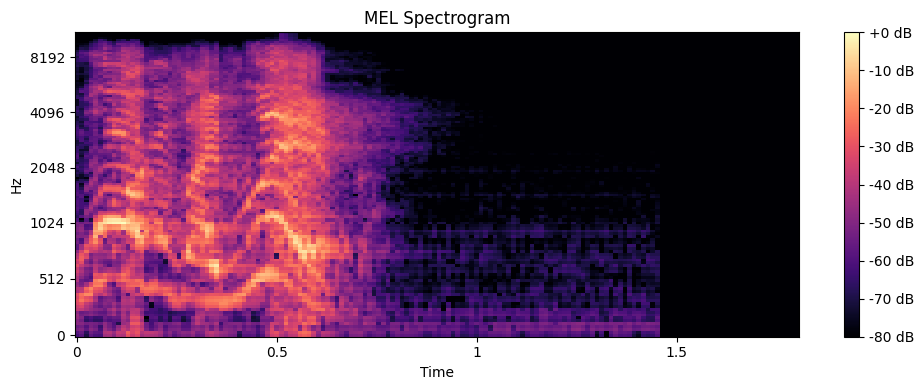

In [3]:
#generates MEL-spectogramms for each elements of padded_soundwaves

sr = 22050
n_fft = 512
mel_spec_array=[]
# generate MEL spectrograms for each padded soundwave
for soundwave in padded_soundwaves:
    mel_spec = librosa.feature.melspectrogram(y=soundwave, sr=sr, n_fft=n_fft, hop_length=int(n_fft/2))
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # convert to decibel scale
    mel_spec_array.append(mel_spec_db)
    # plot the MEL spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=int(n_fft/2), x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('MEL Spectrogram')
plt.tight_layout()
plt.show()

In [6]:
#save labels as unicode characters (useful if we're later using non-latin characters)

# Convert the list to a NumPy array of Unicode strings
labels_array = np.array(all_labels_version1, dtype=np.unicode_)

# Save the array to a .npy file
np.save('processing_dataset/labels.npy', labels_array)
print("labels saved!")


labels saved!


In [4]:
#Save data in - final_dataset/
import numpy as np

mel_spec_array = np.array(mel_spec_array)
np.save("final_dataset/spectrograms.npy", mel_spec_array)
print("spectrogramms saved!")  


spectrogramms saved!


In [ ]:
#load the data
import csv
import numpy as np

spectrograms = np.load("final_dataset/spectrograms.npy")
print("Spectrogramms load finished")


In [ ]:

#Deletes all the .anvil files in Labels since those are useless for our use in this project. 

import glob
# Directory containing the audio files
audio_dir = "../labels/"

# List all the .anvil files in the directory
anvil_files = glob.glob(os.path.join(audio_dir, "*.anvil"))

# Loop over all the .anvil files and delete them
for file_path in anvil_files:
    os.remove(file_path)
print("finished")